In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from datasets import load_dataset
from torch.optim import AdamW
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.backends.cudnn.conv.fp32_precision = 'tf32'
torch.backends.cudnn.benchmark = True

In [ ]:
torch.cuda.is_available()

True

In [ ]:
dataset = load_dataset("ag_news")
train_data = dataset['train']
test_data = dataset['test']

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=64)

train_data = train_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

columns = ['input_ids', 'attention_mask', 'label']
train_data.set_format(type='torch', columns=columns)
test_data.set_format(type='torch', columns=columns)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
import torch.nn as nn

class TransformerClassifier(nn.Module):
    def __init__(self, model_name, num_classes=4, dropout_rate=0.3):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        hidden_size = self.transformer.config.hidden_size
        self.bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.bn(cls_output)
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TransformerClassifier(model_name).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

EPOCHS = 5
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

In [ ]:
train_losses, train_f1s, val_f1s = [], [], []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    all_preds, all_labels = [], []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", ncols=100)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        current_f1 = f1_score(all_labels, all_preds, average='macro')
        loop.set_postfix(loss=epoch_loss/ (len(all_preds)/train_loader.batch_size), f1=current_f1)

Epoch 5: 100%|███████████████████████████| 1875/1875 [11:51<00:00,  2.64it/s, f1=0.982, loss=0.0532]


Test Accuracy: 0.9441, Test F1: 0.9441


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_f1 = f1_score(all_labels, all_preds, average='macro')
test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")

Test Accuracy: 0.9441, Test F1: 0.9441


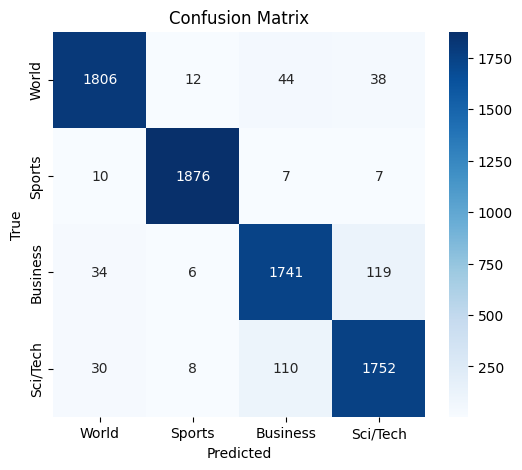

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset['train'].features['label'].names,
            yticklabels=dataset['train'].features['label'].names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()